In [1]:
!git clone https://github.com/filmer2002/Udemy_The_Complete_Self-Driving_Car_Course-Applied_Deep_Learning

fatal: destination path 'Udemy_The_Complete_Self-Driving_Car_Course-Applied_Deep_Learning' already exists and is not an empty directory.


In [2]:
!ls

sample_data  Udemy_The_Complete_Self-Driving_Car_Course-Applied_Deep_Learning


In [3]:
!ls Udemy_The_Complete_Self-Driving_Car_Course-Applied_Deep_Learning

Deep_Neural_Network.ipynb  Regression.ipynb
MNIST_CNN_1.ipynb	   selfdrivingcar
MNIST_CNN_2.ipynb	   The_Perceptron.ipynb
MNIST_DeepLearning.ipynb   Traffic_Signs_Starter_Project_2.ipynb
MultiClass.ipynb	   Traffic_Signs_Starter_Project_3.ipynb
Numpy.ipynb		   Traffic_Signs_Starter_Project.ipynb
README.md		   Untitled.ipynb


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

Using TensorFlow backend.


In [5]:
data_path = 'Udemy_The_Complete_Self-Driving_Car_Course-Applied_Deep_Learning/selfdrivingcar'
colums = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(data_path,'driving_log.csv'), names =colums)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,/Users/waranthornchansawang/Desktop/Udemy_The_Complete_Self-Driving_Car_Course - Applied_Deep_Learning/car/IMG/center_2019_10_11_21_57_55_593.jpg,/Users/waranthornchansawang/Desktop/Udemy_The_Complete_Self-Driving_Car_Course - Applied_Deep_Learning/car/IMG/left_2019_10_11_21_57_55_593.jpg,/Users/waranthornchansawang/Desktop/Udemy_The_Complete_Self-Driving_Car_Course - Applied_Deep_Learning/car/IMG/right_2019_10_11_21_57_55_593.jpg,0.0,0.0,0.0,0.000078
1,/Users/waranthornchansawang/Desktop/Udemy_The_Complete_Self-Driving_Car_Course - Applied_Deep_Learning/car/IMG/center_2019_10_11_21_57_55_695.jpg,/Users/waranthornchansawang/Desktop/Udemy_The_Complete_Self-Driving_Car_Course - Applied_Deep_Learning/car/IMG/left_2019_10_11_21_57_55_695.jpg,/Users/waranthornchansawang/Desktop/Udemy_The_Complete_Self-Driving_Car_Course - Applied_Deep_Learning/car/IMG/right_2019_10_11_21_57_55_695.jpg,0.0,0.0,0.0,0.000078
2,/Users/waranthornchansawang/Desktop/Udemy_The_Complete_Self-Driving_Car_Course - Applied_Deep_Learning/car/IMG/center_2019_10_11_21_57_55_810.jpg,/Users/waranthornchansawang/Desktop/Udemy_The_Complete_Self-Driving_Car_Course - Applied_Deep_Learning/car/IMG/left_2019_10_11_21_57_55_810.jpg,/Users/waranthornchansawang/Desktop/Udemy_The_Complete_Self-Driving_Car_Course - Applied_Deep_Learning/car/IMG/right_2019_10_11_21_57_55_810.jpg,0.0,0.0,0.0,0.000080
3,/Users/waranthornchansawang/Desktop/Udemy_The_Complete_Self-Driving_Car_Course - Applied_Deep_Learning/car/IMG/center_2019_10_11_21_57_55_910.jpg,/Users/waranthornchansawang/Desktop/Udemy_The_Complete_Self-Driving_Car_Course - Applied_Deep_Learning/car/IMG/left_2019_10_11_21_57_55_910.jpg,/Users/waranthornchansawang/Desktop/Udemy_The_Complete_Self-Driving_Car_Course - Applied_Deep_Learning/car/IMG/right_2019_10_11_21_57_55_910.jpg,0.0,0.0,0.0,0.000079
4,/Users/waranthornchansawang/Desktop/Udemy_The_Complete_Self-Driving_Car_Course - Applied_Deep_Learning/car/IMG/center_2019_10_11_21_57_56_027.jpg,/Users/waranthornchansawang/Desktop/Udemy_The_Complete_Self-Driving_Car_Course - Applied_Deep_Learning/car/IMG/left_2019_10_11_21_57_56_027.jpg,/Users/waranthornchansawang/Desktop/Udemy_The_Complete_Self-Driving_Car_Course - Applied_Deep_Learning/car/IMG/right_2019_10_11_21_57_56_027.jpg,0.0,0.0,0.0,0.000078


In [6]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_10_11_21_57_55_593.jpg,left_2019_10_11_21_57_55_593.jpg,right_2019_10_11_21_57_55_593.jpg,0.0,0.0,0.0,0.000078
1,center_2019_10_11_21_57_55_695.jpg,left_2019_10_11_21_57_55_695.jpg,right_2019_10_11_21_57_55_695.jpg,0.0,0.0,0.0,0.000078
2,center_2019_10_11_21_57_55_810.jpg,left_2019_10_11_21_57_55_810.jpg,right_2019_10_11_21_57_55_810.jpg,0.0,0.0,0.0,0.000080
3,center_2019_10_11_21_57_55_910.jpg,left_2019_10_11_21_57_55_910.jpg,right_2019_10_11_21_57_55_910.jpg,0.0,0.0,0.0,0.000079
4,center_2019_10_11_21_57_56_027.jpg,left_2019_10_11_21_57_56_027.jpg,right_2019_10_11_21_57_56_027.jpg,0.0,0.0,0.0,0.000078


[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


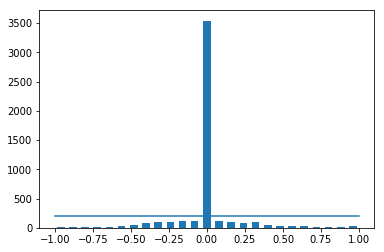

In [7]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
print(bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 4805
removed: 3339
remaining: 1466


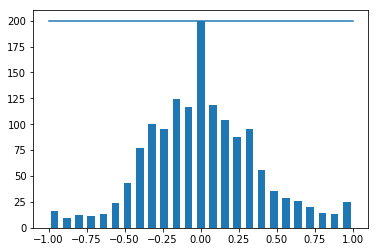

In [8]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [9]:
print(data.iloc[1])
def load_img_steering(data_path, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(data_path, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(data_path,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(data_path,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
 
image_paths, steerings = load_img_steering(data_path + '/IMG', data)

center      center_2019_10_11_21_57_56_896.jpg
left        left_2019_10_11_21_57_56_896.jpg  
right       right_2019_10_11_21_57_56_896.jpg 
steering   -0.390486                          
throttle    0.993309                          
reverse     0                                 
speed       1.88205                           
Name: 12, dtype: object


In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 3518
Valid Samples: 880


Text(0.5, 1.0, 'Validation Set')

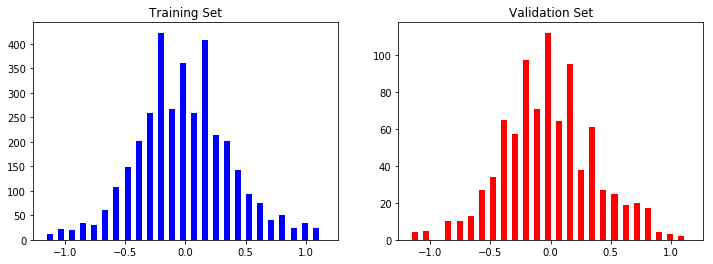

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training Set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation Set')

In [0]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

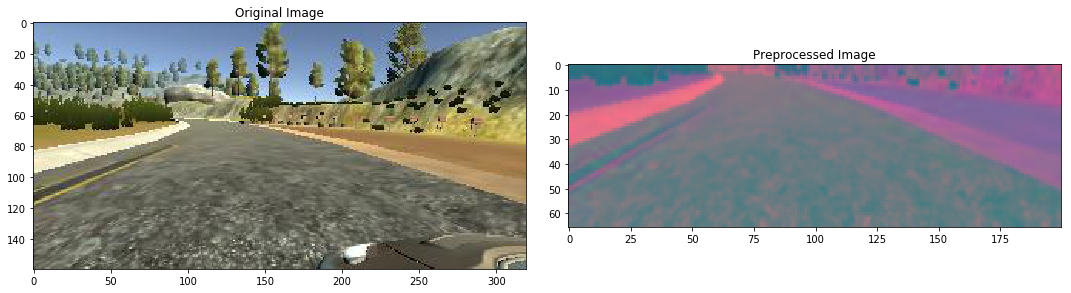

In [13]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [0]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(3518, 66, 200, 3)


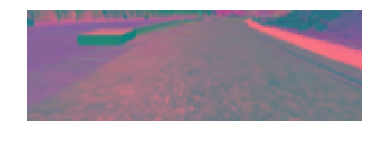

In [15]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Flatten())

  model.add(Dense(100, activation = 'elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation = 'elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(10, activation = 'elu'))
  model.add(Dropout(0.5))
 
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [17]:
model = nvidia_model()
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)            

In [18]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)




Train on 3518 samples, validate on 880 samples
Epoch 1/30





3518/3518 [==============================] - 28s 8ms/step - loss: 0.7436 - val_loss: 0.1243
Epoch 2/30
3518/3518 [==============================] - 28s 8ms/step - loss: 0.1592 - val_loss: 0.1102
Epoch 3/30
3518/3518 [==============================] - 27s 8ms/step - loss: 0.1374 - val_loss: 0.1056
Epoch 4/30
3518/3518 [==============================] - 28s 8ms/step - loss: 0.1334 - val_loss: 0.0995
Epoch 5/30
3518/3518 [==============================] - 28s 8ms/step - loss: 0.1352 - val_loss: 0.1002
Epoch 6/30
3518/3518 [==============================] - 27s 8ms/step - loss: 0.1259 - val_loss: 0.0962
Epoch 7/30
3518/3518 [==============================] - 27s 8ms/step - loss: 0.1239 - val_loss: 0.0959
Epoch 8/30
3518/3518 [==============================] - 28s 8ms/step - loss: 0.1161 - val_loss: 0.0934
Epoch 9/30
3518/3518 [==============================] - 28s 8ms/step - loss: 0.1167 - val_loss: 0.0901
Epoch 10/30
3518/3

Text(0.5, 0, 'Epoch')

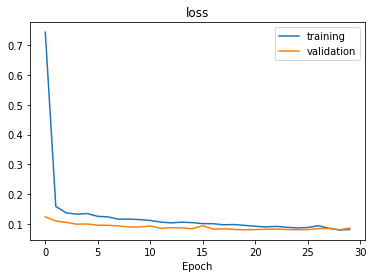

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('Epoch')

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')